In [85]:
import pandas as pd
import numpy as np
from geopy import distance
from geopy.geocoders import Nominatim
import matplotlib.pyplot as plt 
import seaborn as sns
from datetime import datetime, timedelta
import calendar
from pandas.api.types import CategoricalDtype
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split, cross_val_score, cross_val_predict
from sklearn.ensemble import RandomForestClassifier
from sklearn import metrics
import os

# Feature Engineering

In [23]:
#Import data
customers = pd.read_csv(r'https://raw.githubusercontent.com/PixarJunkie/dsc-672-capstone-project/main/data/olist_customers_dataset.csv')
locations = pd.read_csv(r'https://raw.githubusercontent.com/PixarJunkie/dsc-672-capstone-project/main/data/olist_geolocation_dataset.csv')
items = pd.read_csv(r'https://raw.githubusercontent.com/PixarJunkie/dsc-672-capstone-project/main/data/olist_order_items_dataset.csv')
payments = pd.read_csv(r'https://raw.githubusercontent.com/PixarJunkie/dsc-672-capstone-project/main/data/olist_order_payments_dataset.csv')
reviews = pd.read_csv(r'https://raw.githubusercontent.com/PixarJunkie/dsc-672-capstone-project/main/data/olist_order_reviews_dataset.csv')
orders = pd.read_csv(r'https://raw.githubusercontent.com/PixarJunkie/dsc-672-capstone-project/main/data/olist_orders_dataset.csv')
products = pd.read_csv(r'https://raw.githubusercontent.com/PixarJunkie/dsc-672-capstone-project/main/data/olist_products_dataset.csv')
sellers = pd.read_csv(r'https://raw.githubusercontent.com/PixarJunkie/dsc-672-capstone-project/main/data/olist_sellers_dataset.csv')
product_category = pd.read_csv(r'https://raw.githubusercontent.com/PixarJunkie/dsc-672-capstone-project/main/data/product_category_name_translation.csv')
closed_deals = pd.read_csv(r'https://raw.githubusercontent.com/PixarJunkie/dsc-672-capstone-project/main/data/olist_closed_deals_dataset.csv')
marketing_leads = pd.read_csv(r'https://raw.githubusercontent.com/PixarJunkie/dsc-672-capstone-project/main/data/olist_marketing_qualified_leads_dataset.csv')

### Merge Datasets

In [17]:
#Merging Data
merge_df = pd.merge(orders, payments, on = 'order_id', how = 'left')
merge_df = merge_df.merge(customers, on = 'customer_id', how = 'left')
merge_df = merge_df.merge(items, on = 'order_id', how = 'left') 
merge_df = merge_df.merge(products, on = 'product_id', how = 'left')
merge_df = merge_df.merge(product_category, on = "product_category_name", how = 'left')
final_df = merge_df.merge(sellers, on = 'seller_id', how = 'left')

#Add funnel merge for final df
# final_df = merge_df.merge(funnel_merge, on = 'seller_id', how = 'left')

#Drop NAs, check shape, check NANs
print(final_df.shape)
final_df.dropna(inplace=True) 

#Drop unecessary columns
final_df.drop(['product_category_name'], axis = 1, inplace = True)

(118434, 34)


### Create Dummy/Temporal Variables

In [190]:
#Create dummies
dummy_df = final_df.copy()
le = LabelEncoder()
dummy_cols = ['order_status', 'payment_type', 'customer_state', 'customer_city', 'seller_city', 'seller_state', 'product_category_name_english']

for col in dummy_cols:
    dummy_df[col] = le.fit_transform(dummy_df[col])

In [192]:
#Adding Columns

#Change columns to datetime
date_cols = ['order_purchase_timestamp', 'order_delivered_customer_date', 'order_delivered_carrier_date', 'order_estimated_delivery_date', 'shipping_limit_date']
dummy_df[date_cols] = dummy_df[date_cols].apply(pd.to_datetime)

#Create temporal variables variable
dummy_df['order_delivered_month'] = pd.DatetimeIndex(dummy_df.order_purchase_timestamp).month
dummy_df['estimated_delivery_month'] = pd.DatetimeIndex(dummy_df.order_estimated_delivery_date).month
dummy_df['estimated_delivered_days'] = (dummy_df.order_delivered_customer_date - dummy_df.order_estimated_delivery_date).apply(lambda x: x.days)
dummy_df['ordered_delivered_days'] = (dummy_df.order_delivered_customer_date - dummy_df.order_purchase_timestamp).apply(lambda x: x.days)

#Create late column 
dummy_df['late'] = np.where(dummy_df.estimated_delivered_days < 0, 0, 1)

#Months with major holidays
holiday_months = {1: 1, 2: 0, 3: 2, 4: 1, 5: 1, 6: 1, 7: 1, 8: 0, 9: 1, 10: 1, 11: 2, 12: 1}
dummy_df['major_holidays'] = dummy_df.estimated_delivery_month.map(holiday_months)

#Weight per volume derivation 
#Assuming gerneralized volume calc where v = LWH, so w_v = w/LWH
dummy_df['weight_by_volume'] = dummy_df.product_weight_g / (dummy_df.product_length_cm * dummy_df.product_width_cm * dummy_df.product_height_cm)

#Distance 
#Location dict
lat_dict = dict(zip(locations.geolocation_zip_code_prefix, locations.geolocation_lat))
lng_dict = dict(zip(locations.geolocation_zip_code_prefix, locations.geolocation_lng))

#Locations 
dummy_df['customer_lat'] = dummy_df.customer_zip_code_prefix.map(lat_dict)
dummy_df['customer_lng'] = dummy_df.customer_zip_code_prefix.map(lng_dict)
dummy_df['seller_lat'] = dummy_df.seller_zip_code_prefix.map(lat_dict)
dummy_df['seller_lng'] = dummy_df.seller_zip_code_prefix.map(lat_dict)
#Drop rows where zip code returned empty for lat or lng
dummy_df.dropna(subset = ['customer_lat', 'customer_lng', 'seller_lat', 'seller_lng'], how = 'any', inplace = True)
#Zip lat and lng for customer and seller
dummy_df['customer_lat_lng'] = list(zip(dummy_df.customer_lat, dummy_df.customer_lng))
dummy_df['seller_lat_lng'] = list(zip(dummy_df.seller_lat, dummy_df.seller_lng))

#Calculate distance
dummy_df['seller_customer_dist_km'] = dummy_df.apply(lambda x: distance.distance(x.seller_lat_lng, x.customer_lat_lng), axis = 1)

#Drop uneeded columns 
# dummy_df.drop(columns = ['order_id', 'order_status', 'customer_id', 'customer_unique_id', 'product_id', 'seller_id', 'order_purchase_timestamp', 'order_delivered_customer_date', 'order_delivered_carrier_date', 'order_estimated_delivery_date', 'shipping_limit_date', 'order_approved_at'], axis = 1, inplace = True)

# Late Delivery Analysis

In [42]:
late_df = dummy_df[dummy_df.late == 1]

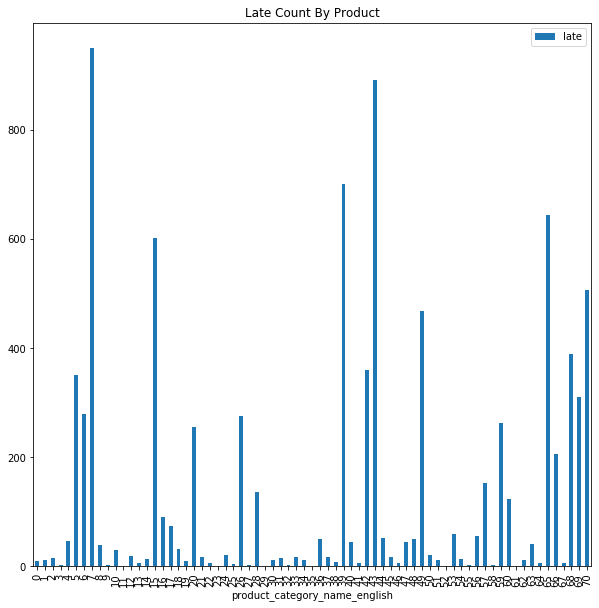

In [13]:
#Late orders by product category
fig = plt.figure()
fig.set_size_inches(10, 10)
plt.title('Late Count By Product')
dummy_df.groupby('product_category_name_english')['late'].sum().plot(kind = 'bar', legend = True)

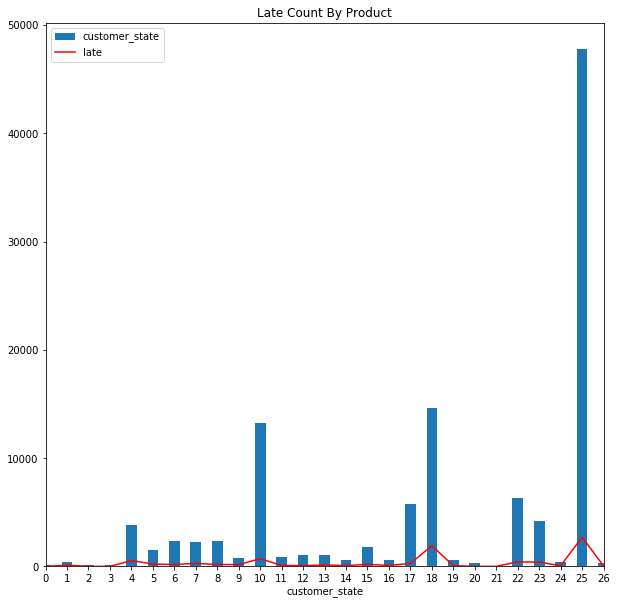

In [46]:
#Late orders by customer state
fig = plt.figure()
fig.set_size_inches(10, 10)
plt.title('Late Count By Product')
dummy_df.groupby('customer_state')['customer_state'].count().plot(kind = 'bar', legend = True)
dummy_df.groupby('customer_state')['late'].sum().plot(kind = 'line', color = 'red', legend = True)
plt.show()

# Correlation Analysis

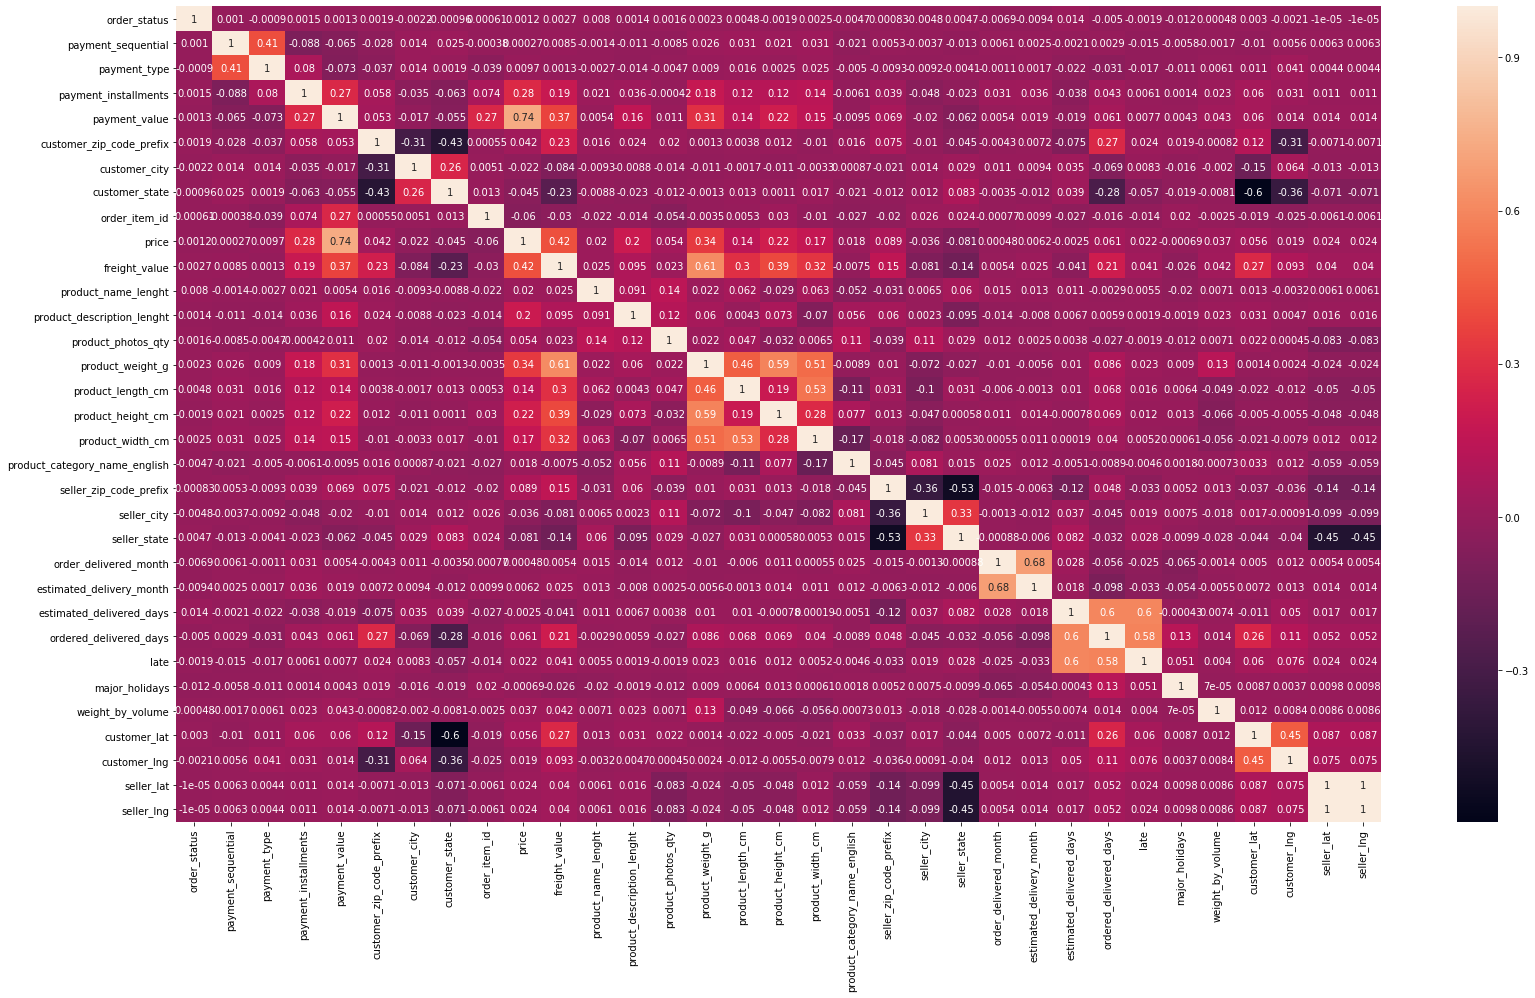

In [195]:
fig = plt.figure()
fig.set_size_inches(27, 15)
corrMatrix = dummy_df.corr()
sns.heatmap(corrMatrix, annot=True)
plt.show()

## Initial Late Model

In [19]:
#Split data
X = dummy_df[dummy_df.columns.difference(['late'])]
Y = dummy_df.late

X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size = 0.3, random_state = 23)
print('X_train shape: ' + str(X_train.shape))
print('X_test shape: ' + str(X_test.shape))
print('y_train shape: ' + str(y_train.shape))
print('y_test shape: ' + str(y_test.shape))

X_train shape: (79356, 26)
X_test shape: (34011, 26)
y_train shape: (79356,)
y_test shape: (34011,)


In [21]:
X_train.order_status.unique()

array([1, 0], dtype=int64)

In [156]:
X_train.columns

Index(['customer_city', 'customer_state', 'customer_zip_code_prefix',
       'estimated_delivered_days', 'freight_value', 'order_item_id',
       'order_month', 'order_status', 'ordered_delivered_days',
       'payment_installments', 'payment_sequential', 'payment_type',
       'payment_value', 'price', 'product_category_name_english',
       'product_description_lenght', 'product_height_cm', 'product_length_cm',
       'product_name_lenght', 'product_photos_qty', 'product_weight_g',
       'product_width_cm', 'seller_city', 'seller_state',
       'seller_zip_code_prefix', 'weight_by_volume'],
      dtype='object')

In [162]:
#Model
rf = RandomForestClassifier(n_estimators = 100)
rf.fit(X_train, y_train)

#Preds
train_pred = rf.predict(X_train)
test_pred = rf.predict(X_test)

#Stats
print('Train Accuracy: ', metrics.accuracy_score(y_train, train_pred))
print('Test Accuracy: ', metrics.accuracy_score(y_test, test_pred))

Train Accuracy:  1.0
Test Accuracy:  1.0


<Figure size 432x288 with 0 Axes>

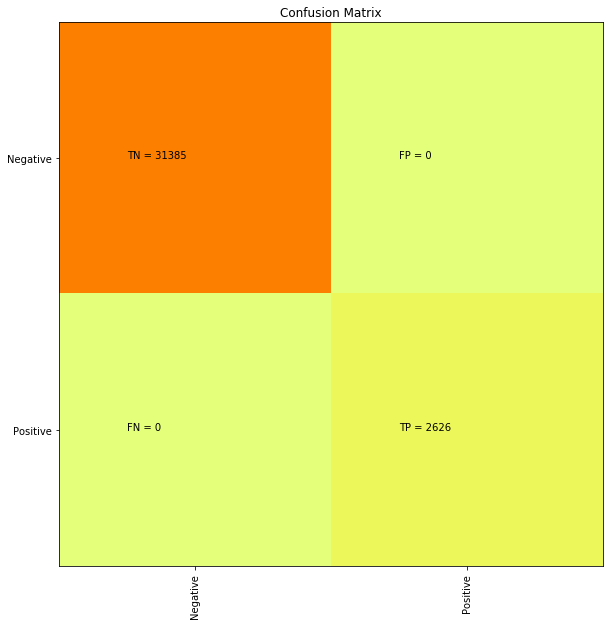

In [165]:
#Confusion matrix
cm = metrics.confusion_matrix(y_test, test_pred)

plt.clf()
fig = plt.figure()
fig.set_size_inches(10, 10)

plt.imshow(cm, interpolation ='nearest', cmap = plt.cm.Wistia)

classNames = ['Negative','Positive']

ax = plt.gca()
ax.tick_params(axis = 'x', colors = 'black')
ax.tick_params(axis = 'y', colors = 'black')
plt.title('Confusion Matrix', color = 'black')
tick_marks = np.arange(len(classNames))
plt.xticks(tick_marks, classNames, rotation = 90)
plt.yticks(tick_marks, classNames)
s = [['TN','FP'], ['FN', 'TP']]

for x in range(2):
    for y in range(2):
        plt.text(y - 0.25, x, str(s[x][y]) + " = " + str(cm[x][y]))